In [ ]:
%pip install --user tensorflow
%pip install --user keras-mdn-layer
%pip install --user tensorflow_probability

In [1]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

bin_count = 151

Create a train and test set split into X (151 predictors) and Y (151 responses). Each predictor and response is a standarized bin density.

In [2]:
from timeit import default_timer as timer

def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins """
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

X_train, X_test, y_train, y_test = create_test_train("dust_training_data_all_bins.csv", test_size=0.05)


Define and compile a mixture density network. We will use one or more layers with many nodes. Then fit the model on the training data

In [6]:
# Number of columns (bin count plus 8 inputs)
l = bin_count + 8

# Number of gaussians to represent the multimodal distribution (number of mixture density models)
k = 50

# Network
input = tf.keras.Input(shape=(l,))

layer = tf.keras.layers.Dense(32, activation='sigmoid', name='baselayer')(input)
layer_2 = tf.keras.layers.Dense(32, activation='sigmoid', name='baselayer2')(layer)
layer_3 = tf.keras.layers.Dense(32, activation='sigmoid', name='baselayer3')(layer_2)

# Connect the mdn layer to the output of our neural network
mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_3)
model = tf.keras.models.Model(input, [mdn_layer])

model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 32)                5120      
_________________________________________________________________
baselayer2 (Dense)           (None, 32)                1056      
_________________________________________________________________
baselayer3 (Dense)           (None, 32)                1056      
_________________________________________________________________
mdn (MDN)                    (None, 15150)             499950    
Total params: 507,182
Trainable params: 507,182
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit = model.fit(x=X_train, y=y_train, batch_size=128, epochs=25, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Epoch 1/25
5346/5346 [==============================] - 130s 24ms/step - loss: -577.6432 - val_loss: -611.8618
Epoch 2/25
5346/5346 [==============================] - 124s 23ms/step - loss: -574.9959 - val_loss: -571.1295
Epoch 3/25
5346/5346 [==============================] - 121s 23ms/step - loss: -593.3415 - val_loss: -610.5536
Epoch 4/25
5346/5346 [==============================] - 119s 22ms/step - loss: -615.1931 - val_loss: -567.3345
Epoch 5/25
5346/5346 [==============================] - 120s 22ms/step - loss: -617.8196 - val_loss: -670.1741
Epoch 6/25
5346/5346 [==============================] - 118s 22ms/step - loss: -633.2107 - val_loss: -661.0657
Epoch 7/25
5346/5346 [==============================] - 117s 22ms/step - loss: -637.5631 - val_loss: -653.1796
Epoch 8/25
5346/5346 [==============================] - 114s 21ms/step - loss: -627.7431 - val_loss: -664.4487
Epoch 9/25
5346/5346 [==============================] - 120s 22ms/step - loss: -657.7715 - val_loss: -704.5410
E

Plot the loss and validation loss for our training and validation.

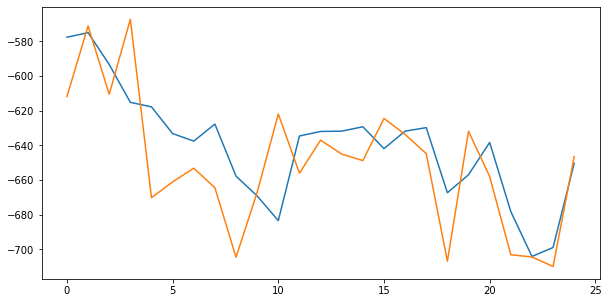

In [9]:
plt.figure(figsize=(10, 5))

plt.plot(fit.history['loss'], label="loss")
plt.plot(fit.history['val_loss'] label="val_loss")
plt.show()

Generate predictions from our test set by taking the 5 samples for our Gaussian models for each bin (151) and averaging the samples per bin together.

In [10]:
start = timer()

# Returns the predictions of the parameters of the distributions and weights
preds = model.predict(X_test)
samples_list = []
# Obtain 5 samples per prediction
for i in range(5):
    samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, bin_count, k, temp=1.0, sigma_temp=1.0))

# Average the samples for our predicitons
y_samples = np.mean(np.array(samples_list),axis=0)
y_samples = y_samples.reshape(len(X_test),bin_count)
end = timer()


In [11]:
print(f"Total time taken: {end-start}. Seconds per prediction: {(end-start)/len(preds)}")

Total time taken: 685.2888581361622. Seconds per prediction: 0.01712494335247925


Calculate the entropy between our predictions and true distribution of dust particles to see how well we did (closer to 0 is better)

In [12]:
from scipy.stats import entropy
ent = []
# Turn all negative preds to 0
y_samples = np.clip(y_samples,0, a_max=None)
for i in range(len(y_test)):
     e = entropy(y_samples[i], y_test.iloc[i])
     ent.append(e if e != np.inf else 1000)   
display(pd.DataFrame(ent).describe())

,0
count,40017.000000
mean,181.545584
std,281.022547
min,0.382958
25%,50.875075
50%,95.708426
75%,144.027112
max,1000.000000


| Run | # Mixtures | Layers | Nodes | activation | epochs | Min Entropy | Avg Entropy |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 20 | 1 | 151 | sigmoid | 100 | 0.639 | 194 | 
| 2 | 50 | 2 | 128, 64 | sigmoid | 100 | 0.268 | 182 |
| 3 | 50 | 3 | 32, 32, 32 | sigmoid | 25 | 0.383 | 181.54 |

Randomnly plot 4 of the predictions versus the true value.

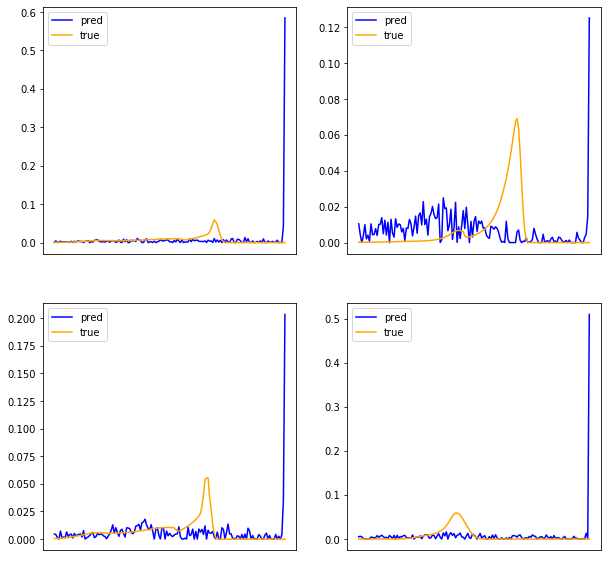

In [15]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test), size=1)[0]
    test_pred = y_samples[i]
    true = y_test.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()